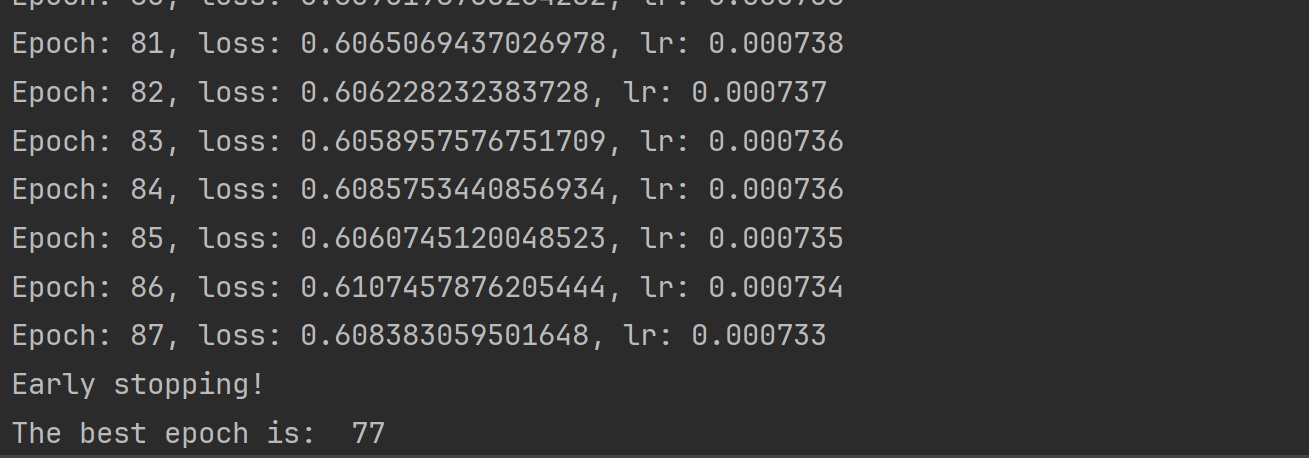

In [114]:
import argparse
import logging

import torch
import yaml

parser = argparse.ArgumentParser(description="GAT")
parser.add_argument(
    "--task",
    type=str,
    default="classification",
    choices=["classification", "clustering"],
)
parser.add_argument("--dataset", type=str, default="acm")
args, _ = parser.parse_known_args()


def load_best_configs(args, path):
    with open(path, "r") as f:
        configs = yaml.load(f, yaml.FullLoader)

    if args.dataset not in configs:
        logging.info("Best args not found")
        return args

    configs = configs[args.dataset]

    for k, v in configs.items():
        if "lr" in k or "weight_decay" in k:
            v = float(v)
        setattr(args, k, v)
    print("------ Use best configs ------")
    return args

In [116]:
parser = argparse.ArgumentParser(description="GAT")
parser.add_argument(
    "--task",
    type=str,
    default="classification",
    choices=["classification", "clustering"],
)
parser.add_argument("--dataset", type=str, default="acm")
args, _ = parser.parse_known_args()

args = load_best_configs(args, "../myHGMAE/configs.yml")
args

------ Use best configs ------


Namespace(task='classification', dataset='acm', in_dim=1902, hidden_dim=1024, category='paper', feat_drop=0.2, attn_drop=0.5, negative_slope=0.2, n_labels=3, nei_num=2, norm='batchnorm', num_heads=4, num_layers=2, num_out_heads=1, residual=False, mp_edge_recon_loss_weight=1, mp_edge_mask_rate=0.6, mp_edge_gamma=3, node_mask_rate='0.5,0.005,0.8', attr_restore_loss_weight=1, attr_restore_gamma=1, attr_replace_rate=0.2, attr_unchanged_rate=0.3, mp2vec_negative_size=5, mp2vec_window_size=5, mp2vec_batch_size=256, mp2vec_rw_length=10, mp2vec_walks_per_node=2, mp2vec_train_epoch=20, mp2vec_train_lr=0.01, mp2vec_feat_dim=256, mp2vec_feat_pred_loss_weight=0.1, mp2vec_feat_gamma=1, mp2vec_feat_drop=0.2, optimizer='adam', patience=10, gpu=0, mae_epochs=1000, eva_lr=0.01, eva_wd=0.0005, scheduler=True, scheduler_gamma=0.999, l2_coef=0, lr=0.0008)

In [117]:
import dgl

# from openhgnn.dataset.NodeClassificationDataset import OHGB_NodeClassification

# acm = OHGB_NodeClassification("ohgbn-acm", raw_dir="./dataset", logger=None)
# hg = acm.g
# metapaths_dict = acm.meta_paths_dict
# h_dict = hg.ndata["h"]

# mp2vec_feat_dict = hg.ndata["pspap_m2v_emb"].copy()
# mp2vec_feat_dict
# for k, v in hg.ndata["pspap_m2v_emb"].items():
#     mp2vec_feat_dict[k] = torch.concat([mp2vec_feat_dict[k], v], dim=1)

(hg,),_=dgl.load_graphs('./data/acm4hgmae.bin')
meta_paths_dict = {
    "PAP": [("paper", "paper-author", "author"), ("author", "author-paper", "paper")],
    "PSP": [
        ("paper", "paper-subject", "subject"),
        ("subject", "subject-paper", "paper"),
    ],
}

In [118]:
h_dict=hg.ndata['h']

# Train

In [124]:
import importlib
import hgmae
import torch

importlib.reload(hgmae)
from hgmae import HGMAE

In [126]:
torch.cuda.empty_cache()

In [127]:
model = HGMAE.build_model_from_args(args, hg, meta_paths_dict).to("cuda")


In [66]:
model(hg.to('cuda'),h_dict,epoch=1)

tensor(1.2207, device='cuda:0', grad_fn=<AddBackward0>)

In [131]:
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.l2_coef)
scheduler = torch.optim.lr_scheduler.ExponentialLR(
    optimizer, gamma=args.scheduler_gamma
)

In [132]:
device = "cuda"
best_model_state_dict = None
cnt_wait = 0
best = 1e12
best_t = 0
for epoch in range(args.mae_epochs):
    model.train()
    optimizer.zero_grad()
    loss = model.forward(hg.to("cuda"), h_dict, epoch=epoch)

    print(
        f"Epoch: {epoch}, loss: {loss.item()}, lr: {optimizer.param_groups[0]['lr']:.6f}"
    )
    if loss < best:
        best = loss
        best_t = epoch
        cnt_wait = 0
        best_model_state_dict = model.state_dict()
    else:
        cnt_wait += 1

    if cnt_wait == args.patience:
        print("Early stopping!")
        break
    loss.backward()
    optimizer.step()
    scheduler.step()

Training MetaPath2Vec feat by given metapaths_dict 
Metapath for training mp2vec models: ['paper', 'author', 'paper', 'subject', 'paper', 'author', 'paper', 'subject', 'paper']


100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


Epoch: 0, loss: 1.2208380699157715, lr: 0.000800
Epoch: 1, loss: 0.9707701802253723, lr: 0.000799
Epoch: 2, loss: 0.8775665760040283, lr: 0.000798
Epoch: 3, loss: 0.8171495795249939, lr: 0.000798
Epoch: 4, loss: 0.7830880880355835, lr: 0.000797
Epoch: 5, loss: 0.7541024684906006, lr: 0.000796
Epoch: 6, loss: 0.7218714952468872, lr: 0.000795
Epoch: 7, loss: 0.6833176016807556, lr: 0.000794
Epoch: 8, loss: 0.6411217451095581, lr: 0.000794
Epoch: 9, loss: 0.6208299398422241, lr: 0.000793
Epoch: 10, loss: 0.6131232380867004, lr: 0.000792
Epoch: 11, loss: 0.6078023314476013, lr: 0.000791
Epoch: 12, loss: 0.6051698923110962, lr: 0.000790
Epoch: 13, loss: 0.6042694449424744, lr: 0.000790
Epoch: 14, loss: 0.6046954393386841, lr: 0.000789
Epoch: 15, loss: 0.6049566864967346, lr: 0.000788
Epoch: 16, loss: 0.6032511591911316, lr: 0.000787
Epoch: 17, loss: 0.6008901596069336, lr: 0.000787
Epoch: 18, loss: 0.6007040739059448, lr: 0.000786
Epoch: 19, loss: 0.6002441644668579, lr: 0.000785
Epoch: 20,

In [140]:
print("The best epoch is: ", best_t)
model.load_state_dict(best_model_state_dict)

The best epoch is:  30


<All keys matched successfully>

In [142]:
# model.eval()
embeds = model.get_embeds(hg.to("cuda"), h_dict)

# Eval

In [146]:
import torch.nn as nn
from sklearn.metrics import f1_score, roc_auc_score
import torch.nn.functional as F
num_classes = 3

In [178]:
labels = hg.ndata["label"]["paper"].long().to(device)
train_mask = hg.ndata["train_40"]["paper"].bool()
val_mask =   hg.ndata["val_40"]["paper"].bool()
test_mask =   hg.ndata["test_40"]["paper"].bool()

train_embs = embeds[train_mask]
val_embs =   embeds[val_mask]
test_embs =  embeds[test_mask]


train_lbls = labels[train_mask].reshape(-1)
val_lbls = labels[val_mask].reshape(-1)
test_lbls = labels[test_mask].reshape(-1)


In [193]:
log = hgmae.LogReg(args.hidden_dim, num_classes).to(device)
opt = torch.optim.Adam(log.parameters(), lr=args.eva_lr, weight_decay=args.eva_wd)
xent = nn.CrossEntropyLoss()

val_accs = []
test_accs = []
val_micro_f1s = []
test_micro_f1s = []
val_macro_f1s = []
test_macro_f1s = []
logits_list = []

for iter_ in range(200):
    log.train()
    opt.zero_grad()

    logits = log(train_embs)
    loss = xent(logits, train_lbls)

    loss.backward()
    opt.step()

    print(iter_,loss.item())

    # val
    logits = log(val_embs)
    preds = torch.argmax(logits, dim=1)
    val_acc = torch.sum(preds == val_lbls).float() / val_lbls.shape[0]
    val_f1_macro = f1_score(val_lbls.cpu(), preds.cpu(), average="macro")
    val_f1_micro = f1_score(val_lbls.cpu(), preds.cpu(), average="micro")
    val_accs.append(val_acc.item())
    val_macro_f1s.append(val_f1_macro)
    val_micro_f1s.append(val_f1_micro)

    # test
    logits = log(test_embs)
    preds = torch.argmax(logits, dim=1)
    test_acc = torch.sum(preds == test_lbls).float() / test_lbls.shape[0]
    test_f1_macro = f1_score(test_lbls.cpu(), preds.cpu(), average="macro")
    test_f1_micro = f1_score(test_lbls.cpu(), preds.cpu(), average="micro")
    test_accs.append(test_acc.item())
    test_macro_f1s.append(test_f1_macro)
    test_micro_f1s.append(test_f1_micro)
    logits_list.append(logits)

0 1.1013238430023193
1 1.1144977807998657
2 1.1028416156768799
3 1.0997530221939087
4 1.1057809591293335
5 1.1030828952789307
6 1.0973570346832275
7 1.0974820852279663
8 1.1002614498138428
9 1.0999432802200317
10 1.0971468687057495
11 1.0952448844909668
12 1.0955692529678345
13 1.0964927673339844
14 1.096134066581726
15 1.0945616960525513
16 1.0931504964828491
17 1.0930449962615967
18 1.0936437845230103
19 1.0933101177215576
20 1.091966152191162
21 1.0910112857818604
22 1.0910086631774902
23 1.0911195278167725
24 1.0906163454055786
25 1.0897276401519775
26 1.0890685319900513
27 1.08885657787323
28 1.0887471437454224
29 1.088311791419983
30 1.0875837802886963
31 1.0870251655578613
32 1.0868371725082397
33 1.0866239070892334
34 1.0860854387283325
35 1.0854889154434204
36 1.085121750831604
37 1.0848690271377563
38 1.0845075845718384
39 1.084017276763916
40 1.0835492610931396
41 1.0832159519195557
42 1.0829260349273682
43 1.0825213193893433
44 1.0820504426956177
45 1.081676959991455
46 1.0

In [194]:
max_iter = val_accs.index(max(val_accs))
print("acc:", test_accs[max_iter])
max_iter = val_macro_f1s.index(max(val_macro_f1s))
print("f1 macro:", test_macro_f1s[max_iter])
max_iter = val_micro_f1s.index(max(val_micro_f1s))
print("f1 micro:", test_micro_f1s[max_iter])
best_logits = logits_list[max_iter]
best_proba = F.softmax(best_logits, dim=1)
auc_score = roc_auc_score(
    y_true=test_lbls.detach().cpu().numpy(),
    y_score=best_proba.detach().cpu().numpy(),
    multi_class="ovr",
)
print('auc:',auc_score)

acc: 0.8170000314712524
f1 macro: 0.799338062828534
f1 micro: 0.817
auc: 0.8901319882696476
